In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25


In [2]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/Python')

# # CNN Class
# import Class.CNN_AE_0 as CNN_AE
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF
# import Function.myDataset as mD


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

Import Images

In [4]:
#%% Import image
dl_img_content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
dl_img_style = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# init the target image
img_target = np.random.randint(low=0, high=255, size=dl_img_content.shape, dtype=np.uint8)

# check shape
print(dl_img_content.shape)
print(dl_img_style.shape)
print(img_target.shape)


(1675, 3000, 3)
(4000, 3223, 3)
(1675, 3000, 3)


Text(0.5, 1.0, 'Init Target')

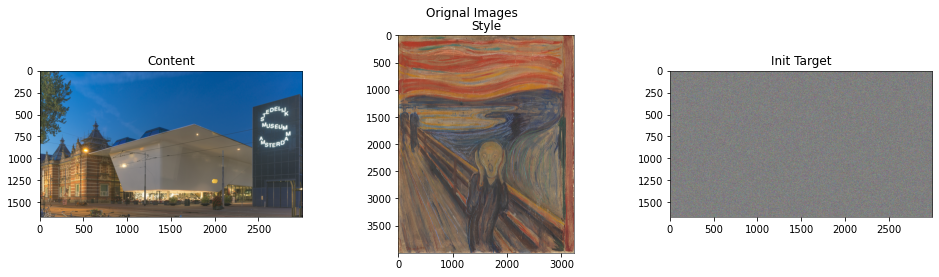

In [5]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Orignal Images')

# content
axs[0].imshow(dl_img_content)
axs[0].set_title('Content')

# style
axs[1].imshow(dl_img_style)
axs[1].set_title('Style')

# target
axs[2].imshow(img_target)
axs[2].set_title('Init Target')


In [6]:
#%% Transformations
transform = T.Compose([ 
                        T.ToTensor(), # normalizes to range [0,1]   
                        T.Resize(256), # resize to fit the net
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization with recommended values
                        # T.RandomHorizontalFlip(p=.5),
                        # T.Normalize(0.5, 0.5),
                        # T.ToPILImage(),
                        # T.RandomVerticalFlip(p=.5),
                        # T.RandomRotation(90),        
                       ])

# apply the transform and send to deivce
img_content = transform(dl_img_content).unsqueeze(0).to(device)
img_style = transform(dl_img_style).unsqueeze(0).to(device)
img_target = transform(img_target).unsqueeze(0).to(device)

# add dimension
# img_content = img_content[None, :, :, :]
# img_style = img_style[None, :, :, :]
# img_target = img_target[None, :, :, :]

# check shape
print(img_content.shape)
print(img_style.shape)
print(img_target.shape)


torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])
torch.Size([1, 3, 256, 458])


Text(0.5, 1.0, 'Init Target')

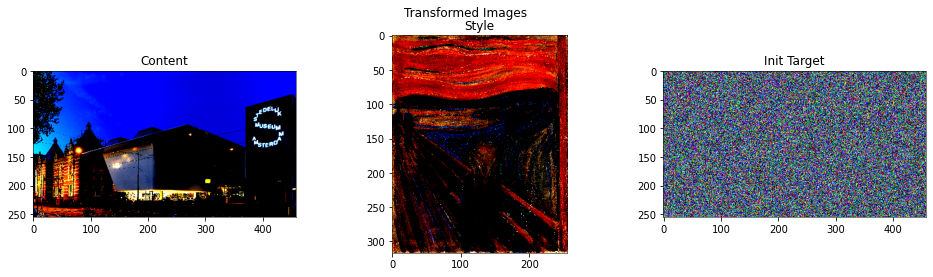

In [8]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Transformed Images')

# content
img = img_content[0].permute(1, 2, 0).cpu()
axs[0].imshow(img)
axs[0].set_title('Content')

# style
img = img_style[0].permute(1, 2, 0).cpu()
axs[1].imshow(img)
axs[1].set_title('Style')

# target
img = img_target[0].permute(1, 2, 0).cpu()
axs[2].imshow(img)
axs[2].set_title('Init Target')


Text(0.5, 1.0, 'Init Target')

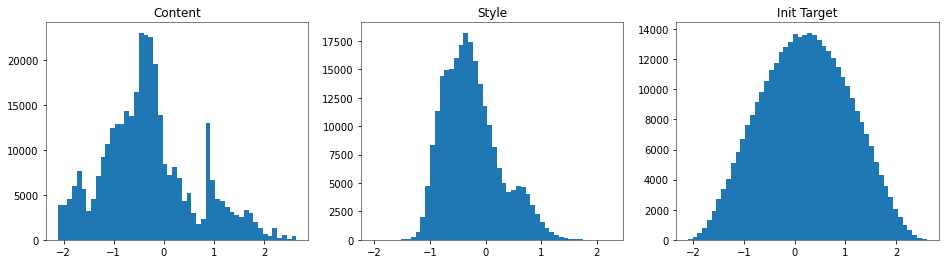

In [10]:
# check value in the img

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# plot hist
x = img_content.cpu().view(-1, 1).detach().numpy()
axs[0].hist(x, 50)
axs[0].set_title('Content')

# plot hist
x = img_style.cpu().view(-1, 1).detach().numpy()
axs[1].hist(x, 50)
axs[1].set_title('Style')

# plot hist
x = img_target.cpu().view(-1, 1).detach().numpy()
axs[2].hist(x, 50)
axs[2].set_title('Init Target')


Import Model

In [11]:
# Import net
vgg19 = torchvision.models.vgg19(weights=True)
summary(vgg19.to(device), (3, 96, 96))


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [12]:
#%% Freeze all the layers
for p in vgg19.named_parameters():
  p[1].requires_grad = False
  print(f'{p[0]}:requires_grad = {p[1].requires_grad}')

# switch to eval mode
vgg19.eval();

# send to GPU
vgg19.to(device);

features.0.weight:requires_grad = False
features.0.bias:requires_grad = False
features.2.weight:requires_grad = False
features.2.bias:requires_grad = False
features.5.weight:requires_grad = False
features.5.bias:requires_grad = False
features.7.weight:requires_grad = False
features.7.bias:requires_grad = False
features.10.weight:requires_grad = False
features.10.bias:requires_grad = False
features.12.weight:requires_grad = False
features.12.bias:requires_grad = False
features.14.weight:requires_grad = False
features.14.bias:requires_grad = False
features.16.weight:requires_grad = False
features.16.bias:requires_grad = False
features.19.weight:requires_grad = False
features.19.bias:requires_grad = False
features.21.weight:requires_grad = False
features.21.bias:requires_grad = False
features.23.weight:requires_grad = False
features.23.bias:requires_grad = False
features.25.weight:requires_grad = False
features.25.bias:requires_grad = False
features.28.weight:requires_grad = False
feature

In [13]:
# check layer structure
vgg19


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
# check convolution layer structure
vgg19.features


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Functions

In [16]:
# push image function

def getFeatmap(net, img_in):

  # init vars
  featMap = []
  featMapName = []
  count = 0

  for i in range(len(net.features)):
    # push input image through every layer
    img_in = net.features[i](img_in)

    # store result each convolution layer
    if 'Conv2d' in str(net.features[i]):
      featMap.append(img_in)
      featMapName.append(f'{str(vgg19.features[i])[:6]}_{count}')
      count += 1

  return featMap, featMapName, count


In [17]:
# compute gram matrix

def gramMatrix(featMap):

  _, C, H, W = featMap.shape # chanel, height, width
  # reshape to 2D
  featMap = featMap.reshape(C, H*W)

  # compute covariance matrix
  gram_mat = torch.mm(featMap, featMap.t()) / featMap.numel()

  return gram_mat


Content Image

In [18]:
# compute the feature maps
featMap_content, featMap_content_name, n_conv = getFeatmap(vgg19, img_content)

# check the shape of each conv later
for i in range(n_conv):
  print(f'{featMap_content_name[i]}: {featMap_content[i].shape}')
  

Conv2d_0: torch.Size([1, 64, 256, 458])
Conv2d_1: torch.Size([1, 64, 256, 458])
Conv2d_2: torch.Size([1, 128, 128, 229])
Conv2d_3: torch.Size([1, 128, 128, 229])
Conv2d_4: torch.Size([1, 256, 64, 114])
Conv2d_5: torch.Size([1, 256, 64, 114])
Conv2d_6: torch.Size([1, 256, 64, 114])
Conv2d_7: torch.Size([1, 256, 64, 114])
Conv2d_8: torch.Size([1, 512, 32, 57])
Conv2d_9: torch.Size([1, 512, 32, 57])
Conv2d_10: torch.Size([1, 512, 32, 57])
Conv2d_11: torch.Size([1, 512, 32, 57])
Conv2d_12: torch.Size([1, 512, 16, 28])
Conv2d_13: torch.Size([1, 512, 16, 28])
Conv2d_14: torch.Size([1, 512, 16, 28])
Conv2d_15: torch.Size([1, 512, 16, 28])


In [19]:
# mean and normalize the feature maps of each conv layer
featMap_content_norm = []
gram_mat_content_norm = []

for i in range(n_conv):

  # feature maps
  fm_norm = torch.mean(featMap_content[i].cpu().squeeze(), axis=0).detach().numpy()
  fm_norm = (fm_norm - np.min(fm_norm)) / (np.max(fm_norm) - np.min(fm_norm)) # min-max feature scaling
  featMap_content_norm.append(fm_norm)

  # gram matrix
  gm_norm = gramMatrix(featMap_content[i]).cpu().squeeze().detach().numpy()
  gm_norm = (gm_norm - np.min(gm_norm)) / (np.max(gm_norm) - np.min(gm_norm)) # min-max feature scaling
  gram_mat_content_norm.append(gm_norm)

# check the shape
for i in range(n_conv):
  print(f'{featMap_content_name[i]}: featMap:{featMap_content_norm[i].shape}, gram:{gram_mat_content_norm[i].shape}')


Conv2d_0: featMap:(256, 458), gram:(64, 64)
Conv2d_1: featMap:(256, 458), gram:(64, 64)
Conv2d_2: featMap:(128, 229), gram:(128, 128)
Conv2d_3: featMap:(128, 229), gram:(128, 128)
Conv2d_4: featMap:(64, 114), gram:(256, 256)
Conv2d_5: featMap:(64, 114), gram:(256, 256)
Conv2d_6: featMap:(64, 114), gram:(256, 256)
Conv2d_7: featMap:(64, 114), gram:(256, 256)
Conv2d_8: featMap:(32, 57), gram:(512, 512)
Conv2d_9: featMap:(32, 57), gram:(512, 512)
Conv2d_10: featMap:(32, 57), gram:(512, 512)
Conv2d_11: featMap:(32, 57), gram:(512, 512)
Conv2d_12: featMap:(16, 28), gram:(512, 512)
Conv2d_13: featMap:(16, 28), gram:(512, 512)
Conv2d_14: featMap:(16, 28), gram:(512, 512)
Conv2d_15: featMap:(16, 28), gram:(512, 512)


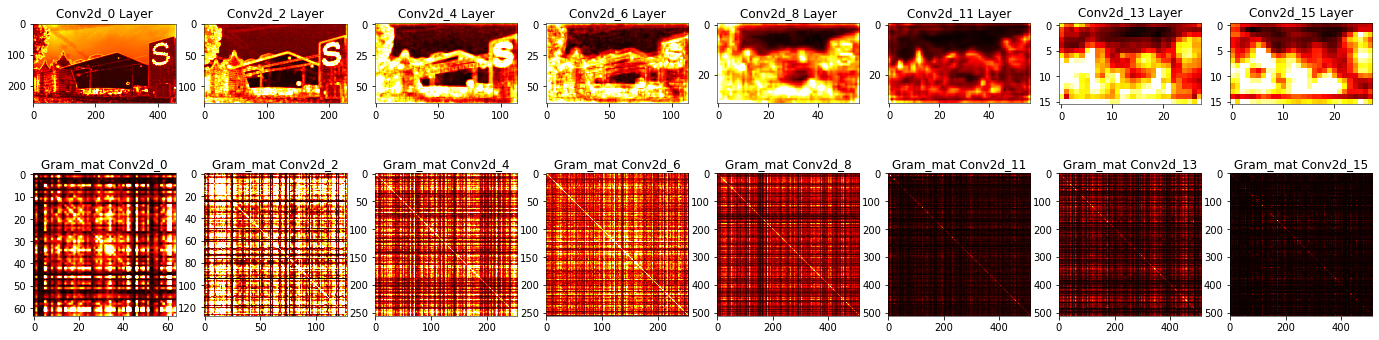

In [20]:
# plot feature maps and gram matrix

fig, axs = plt.subplots(2, 8, figsize=(24, 6))
img_list = [0, 2, 4, 6, 8, 11, 13, 15]

for i, imgi in enumerate(img_list):
  axs[0, i].imshow(featMap_content_norm[imgi], cmap='hot', vmax=0.5)
  axs[0, i].set_title(f'{featMap_content_name[imgi]} Layer')

  axs[1, i].imshow(gram_mat_content_norm[imgi], cmap='hot', vmax=0.1)
  axs[1, i].set_title(f'Gram_mat {featMap_content_name[imgi]}')


Style Image

In [21]:
# compute the feature maps
featMap_style, featMap_style_name, n_conv = getFeatmap(vgg19, img_style)

# check the shape of each conv later
for i in range(n_conv):
  print(f'{featMap_style_name[i]}: {featMap_style[i].shape}')
  

Conv2d_0: torch.Size([1, 64, 317, 256])
Conv2d_1: torch.Size([1, 64, 317, 256])
Conv2d_2: torch.Size([1, 128, 158, 128])
Conv2d_3: torch.Size([1, 128, 158, 128])
Conv2d_4: torch.Size([1, 256, 79, 64])
Conv2d_5: torch.Size([1, 256, 79, 64])
Conv2d_6: torch.Size([1, 256, 79, 64])
Conv2d_7: torch.Size([1, 256, 79, 64])
Conv2d_8: torch.Size([1, 512, 39, 32])
Conv2d_9: torch.Size([1, 512, 39, 32])
Conv2d_10: torch.Size([1, 512, 39, 32])
Conv2d_11: torch.Size([1, 512, 39, 32])
Conv2d_12: torch.Size([1, 512, 19, 16])
Conv2d_13: torch.Size([1, 512, 19, 16])
Conv2d_14: torch.Size([1, 512, 19, 16])
Conv2d_15: torch.Size([1, 512, 19, 16])


In [22]:
# mean and normalize the feature maps of each conv layer
featMap_style_norm = []
gram_mat_style_norm = []

for i in range(n_conv):

  # feature maps
  fm_norm = torch.mean(featMap_style[i].cpu().squeeze(), axis=0).detach().numpy()
  fm_norm = (fm_norm - np.min(fm_norm)) / (np.max(fm_norm) - np.min(fm_norm)) # min-max feature scaling
  featMap_style_norm.append(fm_norm)

  # gram matrix
  gm_norm = gramMatrix(featMap_style[i]).cpu().squeeze().detach().numpy()
  gm_norm = (gm_norm - np.min(gm_norm)) / (np.max(gm_norm) - np.min(gm_norm)) # min-max feature scaling
  gram_mat_style_norm.append(gm_norm)

# check the shape
for i in range(n_conv):
  print(f'{featMap_style_name[i]}: featMap:{featMap_style_norm[i].shape}, gram:{gram_mat_style_norm[i].shape}')
  

Conv2d_0: featMap:(317, 256), gram:(64, 64)
Conv2d_1: featMap:(317, 256), gram:(64, 64)
Conv2d_2: featMap:(158, 128), gram:(128, 128)
Conv2d_3: featMap:(158, 128), gram:(128, 128)
Conv2d_4: featMap:(79, 64), gram:(256, 256)
Conv2d_5: featMap:(79, 64), gram:(256, 256)
Conv2d_6: featMap:(79, 64), gram:(256, 256)
Conv2d_7: featMap:(79, 64), gram:(256, 256)
Conv2d_8: featMap:(39, 32), gram:(512, 512)
Conv2d_9: featMap:(39, 32), gram:(512, 512)
Conv2d_10: featMap:(39, 32), gram:(512, 512)
Conv2d_11: featMap:(39, 32), gram:(512, 512)
Conv2d_12: featMap:(19, 16), gram:(512, 512)
Conv2d_13: featMap:(19, 16), gram:(512, 512)
Conv2d_14: featMap:(19, 16), gram:(512, 512)
Conv2d_15: featMap:(19, 16), gram:(512, 512)


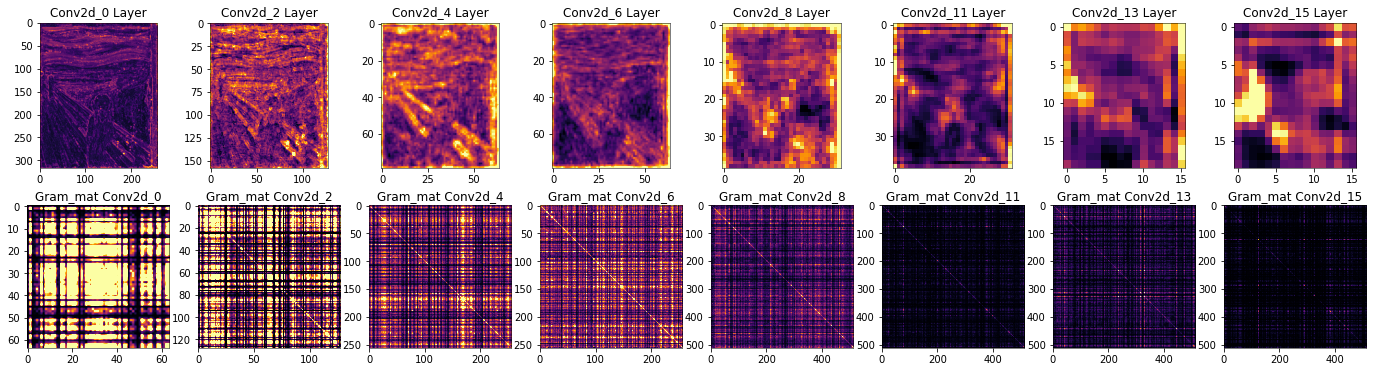

In [23]:
# plot feature maps and gram matrix

fig, axs = plt.subplots(2, 8, figsize=(24, 6))
img_list = [0, 2, 4, 6, 8, 11, 13, 15]

for i, imgi in enumerate(img_list):
  axs[0, i].imshow(featMap_style_norm[imgi], cmap='inferno', vmax=0.5)
  axs[0, i].set_title(f'{featMap_style_name[imgi]} Layer')

  axs[1, i].imshow(gram_mat_style_norm[imgi], cmap='inferno', vmax=0.1)
  axs[1, i].set_title(f'Gram_mat {featMap_style_name[imgi]}')
  

Transfer

In [40]:
# parameters

# layers to use
# content layer
sel_content_layers = np.array([1, 4])
sel_content_layers = [f'Conv2d_{i}' for i in sel_content_layers]

# style layers
sel_style_layers = np.array([1, 2, 3, 4, 5])
sel_style_layers = [f'Conv2d_{i}' for i in sel_style_layers]
weight_style_layers = np.array([1, 0.5, 0.5, 0.2, 1])

# loss style scaling
style_scale = 1e6

# make target image trainable
img_target.requires_grad = True

# training metaparams
epochs = 1500
lr = 0.01

# optimizer
optimizer = torch.optim.RMSprop([img_target], lr=lr)

In [41]:
loss_content_list = []
loss_style_list = []
loss_total_list = []

for epochi in range(epochs): 

  # feature map target image
  featMap_target, featMap_target_name, n_conv = getFeatmap(vgg19, img_target)

  # init vars
  loss_content = 0
  loss_style = 0

  # push through layers
  for layeri in range(n_conv):

    # content loss
    if featMap_target_name[layeri] in sel_content_layers:
      loss_content += torch.mean( (featMap_target[layeri]-featMap_content[layeri])**2 )
      loss_content_list.append(loss_content)

    # style loss
    if featMap_style_name[layeri] in sel_style_layers:
      gm_target = gramMatrix(featMap_style[layeri])
      gm_style = gramMatrix(featMap_target[layeri])
      loss_style += torch.mean( (gm_target-gm_style)**2 ) * weight_style_layers[sel_style_layers.index(featMap_style_name[layeri])]
      loss_style_list.append(loss_style)

  # sum loss
  loss_total = loss_content + style_scale*loss_style
  loss_total_list.append(loss_total)

  # backprop
  optimizer.zero_grad()
  loss_total.backward()
  optimizer.step()

  print(f'epoch: {epochi}/{epochs}') if epochi%100==0 else None

epoch: 0/1500
epoch: 100/1500
epoch: 200/1500
epoch: 300/1500
epoch: 400/1500
epoch: 500/1500
epoch: 600/1500
epoch: 700/1500
epoch: 800/1500
epoch: 900/1500
epoch: 1000/1500
epoch: 1100/1500
epoch: 1200/1500
epoch: 1300/1500
epoch: 1400/1500


In [43]:
# apply activation
res_img_target = torch.sigmoid(img_target.cpu())

Text(0.5, 1.0, 'Transfered Target')

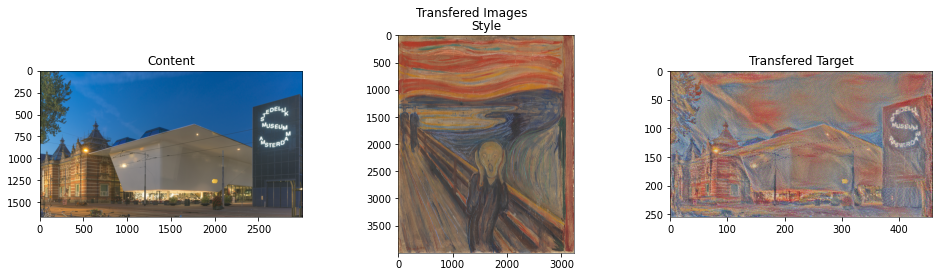

In [46]:
#%% plot images

# create a figure
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Transfered Images')

# content
axs[0].imshow(dl_img_content)
axs[0].set_title('Content')

# style
axs[1].imshow(dl_img_style)
axs[1].set_title('Style')

# target
img = res_img_target[0].detach().permute(1, 2, 0)
axs[2].imshow(img)
axs[2].set_title('Transfered Target')